EfficientNetB3
    
    No of Epochs  Accuracy  Top K accuracy
       4          0.852475     	0.96
       3          0.895734	    0.97  (after manual dataset cleaning)


In [ ]:
#Checking Memory and GPU availability 

# cheking the number of cpu core this system has.
!cat /proc/cpuinfo | grep "cpu cores" | uniq

# GPU info
!nvidia-smi

# Amount of system RAM available to be used.
from psutil import virtual_memory
ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

#finding recursion limit
import sys
print(sys.getrecursionlimit())

#Installing fastai
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html


cpu cores	: 2
Thu May 13 03:49:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

In [ ]:
#Importing Libraries and Initializing fastai
import numpy as np
import pandas as pd
import time

#Mounting drive to store the model for later use 
from google.colab import drive
drive.mount('/content/drive')

from fastai.vision import *
from fastai.metrics import error_rate



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade efficientnet-pytorch
#Importing the Efficient net from pytorch : Original paper implemented in Keras (tpu)
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=7bb8c2cb5e56a2b529a5a902b9180ff29065a11ab06994fcd90314ebc7281e02
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
#Data Download 
path = untar_data(URLs.FOOD)

train_path = '/root/.fastai/data/food-101/train.txt'
test_path = '/root/.fastai/data/food-101/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

#Data Augmentation 
ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40, 40)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': (0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.42, 2.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [ ]:
#Seeding to avoid random pick of data on different models
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

In [ ]:
#user defined funtion for performance evaluation
def evaluate_performance(y_true, y_predict):
  """
    y_true    : True labels of the Images in test dataset 
    y_predict : Predicted labels of the images in test dataset 

    prints the Confusion Matrix , No.Of Misclassifications, Recall and Food class with maximum and minimum accuracy 

    Used for performance evaluation of any true and predicted labels
  """
  import sklearn.metrics as metrics
  print(f"{metrics.classification_report(y_true.items, y_predict)}\n")

  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix

  cm1 = confusion_matrix(y_true.items,y_predict)
  print(cm1)

  print("No.of validation set samples predicted correctly ",sum(cm1.diagonal()))
  print("No.of misclassified samples ", len(y_predict)-sum(cm1.diagonal()))

  #Calculating the True Occurences
  true_occ= []
  for i in range(len(cm1)):
    true_occ.append(sum(cm1[:,i]))

  #Calculating the recall for all the categories
  dia = cm1.diagonal()
  prediction_prob=[]
  for i in range(len(cm1)):
    tmp_prob = dia[i]/true_occ[i]
    prediction_prob.append(tmp_prob)

  incorrect_class = prediction_prob.index(min(prediction_prob))
  correct_class = prediction_prob.index(max(prediction_prob))
  print("Food category with more no.of correct predictions ",y_true.classes[correct_class] )
  print("Food category with min no.of correct predictions ",y_true.classes[incorrect_class] )

In [ ]:
#checking if the valid dataset is the same as other models for ensembling
def crossverify(data_valid_y):
  """
    data_valid_y : labels of the Validation dataset 
    Returns a Boolean value if the validation dataset has the same labels 

    Expecting the same validation data to perform majority vote ensemble
  """
  oop = pd.DataFrame(data_valid_y.items)
  count_valid = oop.value_counts()
  cat_vd = []
  count_vd=[]
  for i in range(101):
    cat_vd.append(i)
    count_vd.append(count_valid[i])
  dict_shift = dict(zip(cat_vd, count_vd))
  count_id = np.array(count_vd)
  if (count_id[0] == 149 and count_id[1]==138 and count_id[2]==150 and count_id[3]==154):
    return True
  else:
    return False

EfficientNetB3

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 2.29E-03


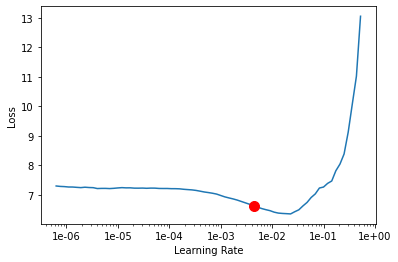

In [ ]:
bs_effb3 = 16 #batch size
img_size_effb3 = 512 #image size
    
seed_everything(40) #setting the seed to 40 

#data bunch creation 
data=(ImageList.from_df(df=train_df,path=path/'images',cols=1)
      .split_by_rand_pct(0.2)
      .label_from_df(cols=0)
      .transform(ds_tfms,size=img_size_effb3)
      .databunch(bs=bs_effb3)
      .normalize(imagenet_stats))

if crossverify(data.valid_dl.y):	  
  #importing pretrained efficientNet B3
  model = EfficientNet.from_pretrained("efficientnet-b3")	  

  top_5 = partial(top_k_accuracy, k=5)

  learneffb3 = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
  learneffb3.split( lambda m: (model._conv_head,) )
  #finding the optimized learning rate 
  learneffb3.lr_find()
  learneffb3.recorder.plot(suggestion=True)
else:
  print("Data Mismatch")

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.853853,1.326938,0.666007,0.880792,28:05
1,1.452610,1.066738,0.732079,0.918086,28:09
2,0.986941,0.696710,0.823960,0.953135,28:22
3,0.705530,0.588879,0.852475,0.960726,28:41


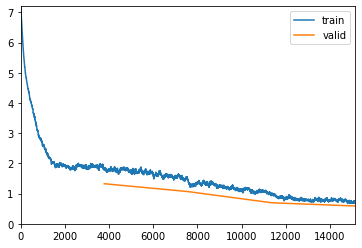

In [ ]:
#training the efficientNetB3 network 
lr = 4e-3
learneffb3.fit_one_cycle(4, max_lr=slice(lr))
learneffb3.save('/content/drive/MyDrive/food101-effNetb3-train-e3')

In [ ]:
#Predicting for the vaidation dataset 
if crossverify(data.valid_dl.y):
  start= time.time()
  Y_valid_predict_effb3 = []
  for img in data.valid_dl.x:
      tmp_predict = learneffb3.predict(img)
      Y_valid_predict_effb3.append(tmp_predict[1]) #predict will return three tensor values along with the probability for each category .We can 
  end = time.time()
  print('Time taken to predict for EfficientNetb3  :',{end - start})
else:
  print('Data Mismatch')

Time taken to predict for EfficientNetb3  : {600.4592323303223}


In [ ]:
#Classification report , precision , recall, f1-score, confusion matrix 
evaluate_performance(data.valid_dl.y,Y_valid_predict_effb3)

              precision    recall  f1-score   support

           0       0.71      0.68      0.69       149
           1       0.80      0.80      0.80       138
           2       0.87      0.88      0.87       150
           3       0.86      0.90      0.88       154
           4       0.83      0.88      0.86       141
           5       0.89      0.77      0.83       159
           6       0.84      0.90      0.87       133
           7       0.91      0.92      0.92       136
           8       0.74      0.73      0.74       164
           9       0.76      0.82      0.78       136
          10       0.86      0.81      0.83       143
          11       0.84      0.85      0.84       145
          12       0.90      0.89      0.89       157
          13       0.90      0.89      0.89       148
          14       0.86      0.76      0.80       149
          15       0.74      0.77      0.75       148
          16       0.92      0.94      0.93       167
          17       0.81    

In [ ]:
#Predictions on the test data before Widget cleaning and TTA 
test_data = (ImageList.from_df(df=test_df, path=path/'images', cols=1)
            .split_none()
            .label_from_df(cols=0)
            .transform(size=512)
            .databunch(bs=16)
            .normalize(imagenet_stats))

top_5 = partial(top_k_accuracy, k=5)
learneffb3 = Learner(test_data, model, metrics=[accuracy, top_5]).to_fp16()
learneffb3.load('/content/drive/MyDrive/food101-effNetb3-train-e3')

In [ ]:
#predicting the test data 
learneffb3.validate(test_data.train_dl)

[0.38830426, tensor(0.8908), tensor(0.9836)]

In [ ]:
#Manual cleaning using fastai the Widget option  
from fastai.widgets import *

data_clean = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_none()
        .label_from_df(cols=0)
        .transform(ds_tfms, size=224)
        .databunch())

learn_cln = Learner(data_clean, model, metrics=[accuracy, top_5]).to_fp16()
learn_cln.load('/content/drive/MyDrive/food101-effNetb3-train-e3')

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)  #retrieving the top losses after the training 

In [ ]:
# manually removing some of the noise in dataset
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [ ]:
#storing the new dataset as cleaned_1.csv
!cp /root/.fastai/data/food-101/cleaned.csv /content/drive/MyDrive/cleaned_1.csv

In [ ]:
#creating new databunch using the cleaned_1 csv 
data_new = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='/content/drive/MyDrive/cleaned_1.csv',
                               ds_tfms=ds_tfms, bs=16, size=512, num_workers=2).normalize(imagenet_stats)

learneffb3 = Learner(data_new, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learneffb3.load('/content/drive/MyDrive/food101-effNetb3-train-e3')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 2.51E-06


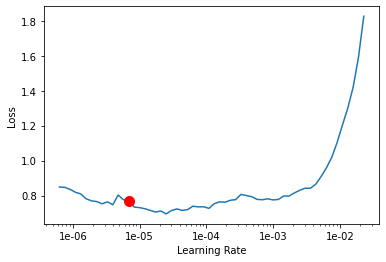

In [ ]:
#finding the optimized learning rate using lr_find()
learneffb3.unfreeze()
learneffb3.lr_find()
learneffb3.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.716326,0.398334,0.894942,0.976624,37:47
1,0.729775,0.396313,0.895008,0.976756,37:41
2,0.744100,0.395266,0.896131,0.976690,37:43
3,0.740419,0.395418,0.895734,0.976690,36:58


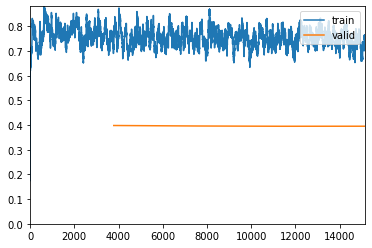

In [ ]:
#training the network using the cleaned csv
lr = 2e-6
learneffb3.fit_one_cycle(4, max_lr=slice(lr))
learneffb3.save('/content/drive/MyDrive/food101-effNetb3-train-ev4')

In [ ]:
#predict the validation and test data
if crossverify(data.valid_dl.y):
  start= time.time()
  Y_valid_predict_effb3_mc = []
  for img in data.valid_dl.x:
      tmp_predict = learneffb3.predict(img)
      Y_valid_predict_effb3_mc.append(tmp_predict[1]) #predict will return three thensor values along with the probability for each category .We can 
  end = time.time()
  print('Time taken to predict for EfficientNetb3  :',{end - start})
else:
  print('Data Mismatch')

Time taken to predict for EfficientNetb3  : {763.6856787204742}


In [ ]:
#Evaluating the performance 
evaluate_performance(data.valid_dl.y,Y_valid_predict_effb3_mc)

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       149
           1       0.82      0.80      0.81       138
           2       0.86      0.88      0.87       150
           3       0.86      0.90      0.88       154
           4       0.83      0.88      0.86       141
           5       0.88      0.79      0.83       159
           6       0.86      0.90      0.88       133
           7       0.91      0.92      0.91       136
           8       0.74      0.74      0.74       164
           9       0.80      0.81      0.81       136
          10       0.84      0.82      0.83       143
          11       0.85      0.85      0.85       145
          12       0.91      0.89      0.90       157
          13       0.89      0.89      0.89       148
          14       0.84      0.76      0.80       149
          15       0.75      0.76      0.76       148
          16       0.91      0.95      0.93       167
          17       0.81    

In [ ]:
#Note : This will take a very long time as we are applying the TTA on the test dataset and predicting. 
# This was not executed due to time constraints but they can be executed using a hardware accelerator
#Validate test accuracy 
log_preds_test, y_test = learneffb3.TTA(ds_type=test_data.train_dl)
accuracy(log_preds_test, y_test)

KeyboardInterrupt: ignored

In [ ]:
if crossverify(data.valid_dl.y):
  start= time.time()
  Y_test_predict_effb3_mc = []
  for img in data.valid_dl.x:
      tmp_predict = learneffb3.predict(img)
      Y_test_predict_effb3_mc.append(tmp_predict[1]) #predict will return three thensor values along with the probability for each category .We can 
  end = time.time()
  print('Time taken to predict for EfficientNetb3  :',{end - start})
else:
  print('Data Mismatch')